# ERCOT Generation Insights
All of the charts below are base upon publicly available data downloaded from ERCOT:
https://www.ercot.com/gridinfo/generation/

Opinionated mappings are as follows:


In [1]:
import pandas as pd

In [2]:
FUEL_HYDRO = 'Hydro'
FUEL_SOLAR = 'Solar'
FUEL_WIND = 'Wind'
FUEL_GAS_CC = 'Gas-CC'
FUEL_GAS = 'Gas'
FUEL_COAL = 'Coal'
FUEL_BIOMASS = 'Biomass'
FUEL_NUCLEAR = 'Nuclear'
FUEL_TYPE_CLEAN = 'Clean'
FUEL_TYPE_FOSSIL = 'Fossil'
FUEL_TYPE_RENEWABLE = 'Renewable'
FUEL_TYPE_OTHER = 'Other'


FUEL_TYPE_MAPPINGS = {
    FUEL_HYDRO: FUEL_TYPE_RENEWABLE,
    FUEL_SOLAR: FUEL_TYPE_RENEWABLE,
    FUEL_WIND: FUEL_TYPE_RENEWABLE,
    FUEL_BIOMASS: FUEL_TYPE_FOSSIL,
    FUEL_COAL: FUEL_TYPE_FOSSIL,
    FUEL_GAS: FUEL_TYPE_FOSSIL,
    FUEL_GAS_CC: FUEL_TYPE_FOSSIL,
    FUEL_NUCLEAR: FUEL_TYPE_CLEAN,
}
def get_fuel_type(fuel):
    return FUEL_TYPE_MAPPINGS.get(fuel, FUEL_TYPE_OTHER)

LOAD_TYPE_BASE_CLEAN = 'Base Clean'
LOAD_TYPE_BASE_FOSSIL = 'Base Fossil'
LOAD_TYPE_PEAKER_FOSSIL = 'Peaker Fossil'
LOAD_TYPE_PEAKER_RENEWABLE = 'Peaker Renewable'
LOAD_TYPE_OTHER = 'Other'

LOAD_TYPE_MAPPINGS = {
    FUEL_HYDRO: LOAD_TYPE_BASE_CLEAN,
    FUEL_SOLAR: LOAD_TYPE_PEAKER_FOSSIL,
    FUEL_WIND: LOAD_TYPE_PEAKER_FOSSIL,
    FUEL_BIOMASS: LOAD_TYPE_BASE_FOSSIL,
    FUEL_COAL: LOAD_TYPE_BASE_FOSSIL,
    FUEL_GAS: LOAD_TYPE_BASE_FOSSIL,
    FUEL_GAS_CC: LOAD_TYPE_PEAKER_FOSSIL,
    FUEL_NUCLEAR: LOAD_TYPE_BASE_CLEAN,
}
    
def get_load_type(fuel):
    return LOAD_TYPE_MAPPINGS.get(fuel, LOAD_TYPE_OTHER)
import json
print('Fuel Type Mappings', json.dumps(FUEL_TYPE_MAPPINGS, indent=True, sort_keys=True))
print('Load Type Mappings', json.dumps(LOAD_TYPE_MAPPINGS, indent=True, sort_keys=True))

Fuel Type Mappings {
 "Biomass": "Fossil",
 "Coal": "Fossil",
 "Gas": "Fossil",
 "Gas-CC": "Fossil",
 "Hydro": "Renewable",
 "Nuclear": "Clean",
 "Solar": "Renewable",
 "Wind": "Renewable"
}
Load Type Mappings {
 "Biomass": "Base Fossil",
 "Coal": "Base Fossil",
 "Gas": "Base Fossil",
 "Gas-CC": "Peaker Fossil",
 "Hydro": "Base Clean",
 "Nuclear": "Base Clean",
 "Solar": "Peaker Fossil",
 "Wind": "Peaker Fossil"
}


In [3]:
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y')
decimalparse = lambda x: float(x.replace(',',''))


def get_df(year: int, month: int):
    df = pd.read_table(
        f'ERCOT/IntGenByFuel{year}{month:02d}.tsv',
        usecols=['Date','Fuel','Total', 'Settlement Type'],
        converters={'Date':dateparse,'Total':decimalparse},
    )
    
        # Find daily total
    alltotal=df.groupby('Date').sum()
    alltotal['Fuel']='ALL SOURCES'
    alltotal['Settlement Type']='Combined'
    alltotal = alltotal.reset_index(drop=False)
    newdf = pd.concat([df, alltotal])

    maxdf = newdf.groupby('Date').max()['Total'].reset_index(drop=False)
    
    newdf = newdf.merge(maxdf, left_on='Date', right_on='Date', suffixes=['', '_y']).rename({'Total_y': 'DailyMax'}, axis=1)

    newdf = newdf.assign(pct=lambda x: x['Total'] / x['DailyMax'])
    
    newdf['FuelType'] = newdf['Fuel'].apply(get_fuel_type)
    newdf['LoadType'] = newdf['Fuel'].apply(get_load_type)
    # Aggregate by month?
    # newdf = newdf.groupby('Fuel').sum().reset_index(drop=False)
    # newdf['Date'] = pd.to_datetime(f'{year}-{month:02d}')

    return newdf

In [4]:
all_dfs = []
for year in (2020, 2021, 2022):
    for month in list(range(1, 13)):
        newdf = get_df(year, month)
        all_dfs.append(newdf)
        if year == 2022 and month == 5:
            break
newdf = pd.concat(all_dfs)
# Ignore incomplete weeks.
newdf = newdf.query('Date < "2022-05-29"')
newdf['Total'] /= 1000

In [5]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [6]:
date_range=f'{newdf.Date.min().strftime("%Y-%m")}-{newdf.Date.max().strftime("%Y-%m")}'
width=1920/2
height=1080/2

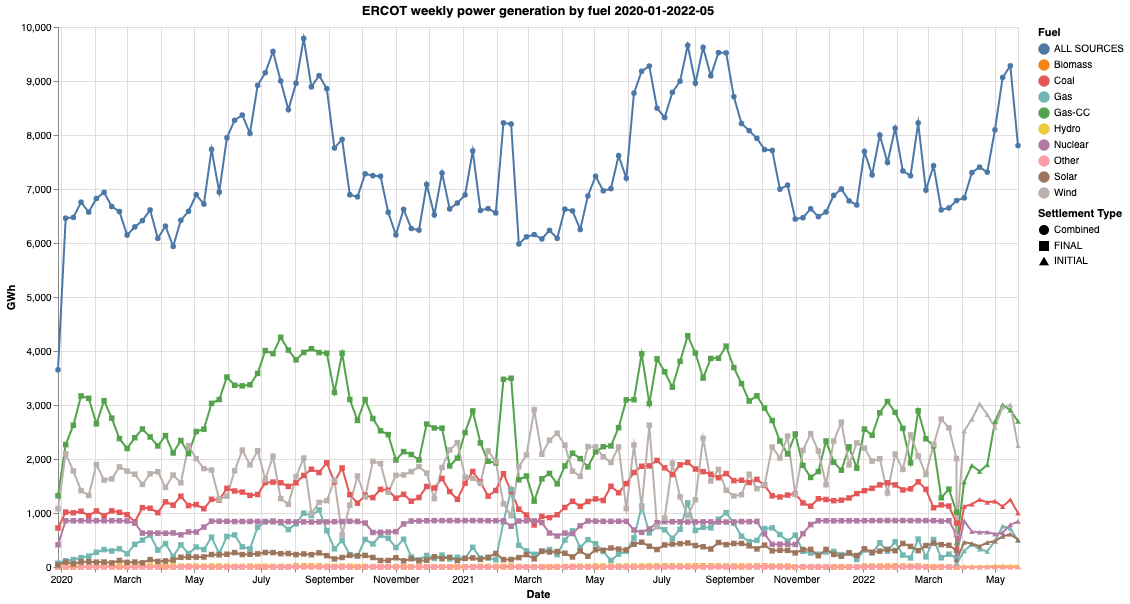

In [7]:
chart = alt.Chart(
    newdf
).transform_timeunit(
    Date='yearweek(Date)'
).transform_aggregate(
    Total='sum(Total)',
    groupby=['Date', 'Fuel', 'Settlement Type', 'FuelType', 'LoadType']
).mark_line().encode(
    x='Date:T',
    y=alt.Y('Total:Q', title='GWh', scale=alt.Scale(domainMin=0)),
    color='Fuel:N',
    tooltip=['Date','Fuel','Total', 'Settlement Type'],
    shape='Settlement Type',
).properties(
    title=f'ERCOT weekly power generation by fuel {date_range}',
    width=width,
    height=height,
)
display(chart)

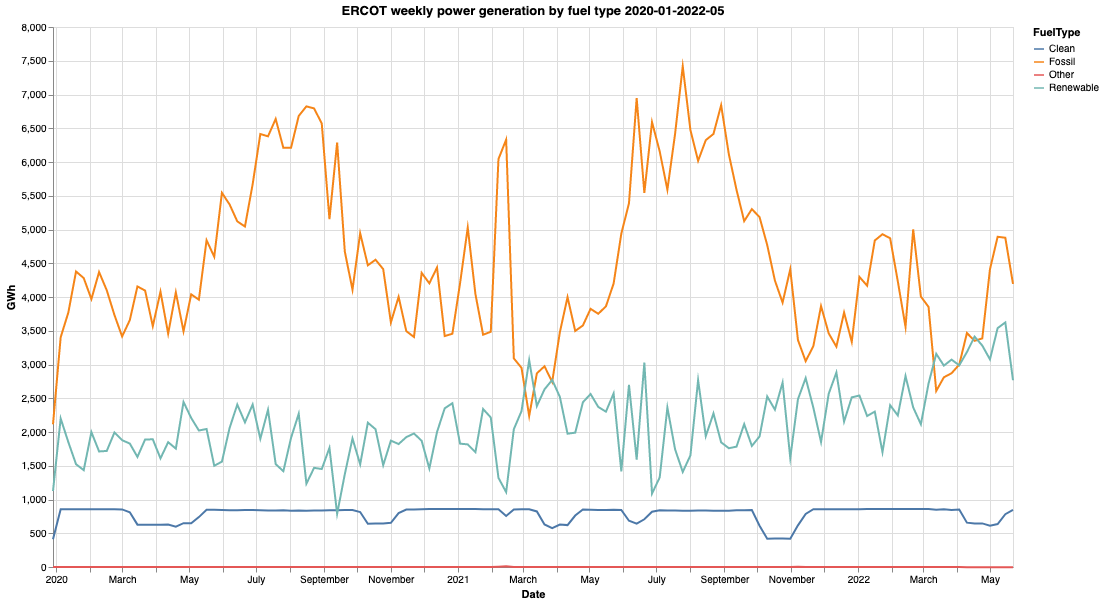

In [8]:
chart = alt.Chart(
    newdf.query('Fuel != "ALL SOURCES"').groupby(['Date', 'FuelType']).sum().reset_index().round(1)
).transform_timeunit(
    Date='yearweek(Date)'
).transform_aggregate(
    Total='sum(Total)',
    groupby=['Date', 'Fuel', 'Settlement Type', 'FuelType', 'LoadType']
).mark_line().encode(
    x='Date:T',
    y=alt.Y('Total:Q', title='GWh', scale=alt.Scale(domainMin=0)),
    color='FuelType:N',
    tooltip=['Date','FuelType','Total']
).properties(
    title=f'ERCOT weekly power generation by fuel type {date_range}',
    width=width,
    height=height,
)
display(chart)

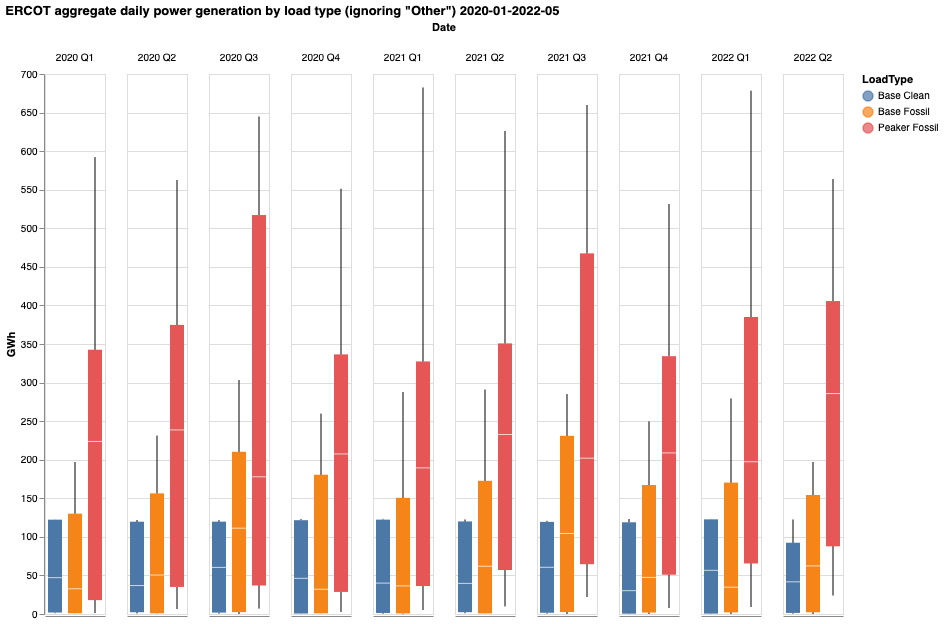

In [9]:
chart = alt.Chart(
    newdf.query('Fuel not in ("ALL SOURCES", "Other")').round(1)
).mark_boxplot(#size=5, extent=0.1
# ).transform_aggregate(
#     # min_pct='min(pct):Q',
#     # max_pct='max(pct):Q',
#     # DailyMax='max(DailyMax):Q',
#     groupby=["Date", 'Fuel']
).encode(
    x=alt.X('LoadType:N', axis=alt.Axis(labels=False, ticks=False), title=None),
    column=alt.Column('yearquarter(Date):T', title='Date'),
    y=alt.Y(
        'Total:Q', title='GWh',
        # 'pct:Q', axis=alt.Axis(format='%'),
            # scale=alt.Scale(domain=[0.0, 1.0])
        scale=alt.Scale(domainMin=0),
    ),
    color='LoadType:N',
    # tooltip=[
    #     alt.Tooltip(alt.repeat("column")),
    #     'Fuel','max(Total)', 'min(pct):Q', 'max(pct):Q'
    # ]
).properties(
    title=f'ERCOT aggregate daily power generation by load type (ignoring "Other") {date_range}',
    # width=width,
    height=height,
)
display(chart)

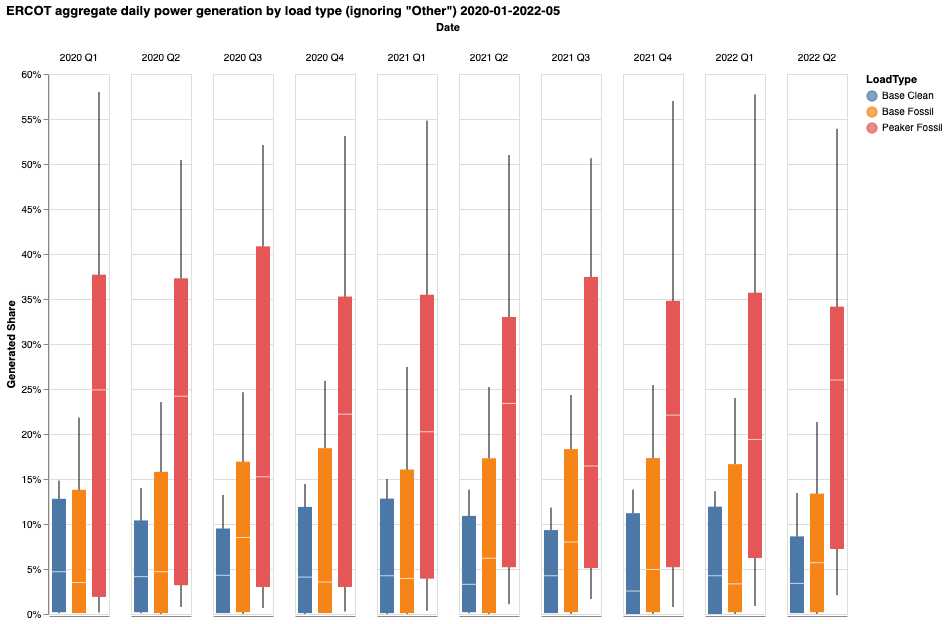

In [10]:
chart = alt.Chart(
    newdf.query('Fuel not in ("ALL SOURCES", "Other")').round(3)
).mark_boxplot(#size=5, extent=0.5
# ).transform_aggregate(
#     # min_pct='min(pct):Q',
#     # max_pct='max(pct):Q',
#     # DailyMax='max(DailyMax):Q',
#     groupby=["Date", 'Fuel']
).encode(
    x=alt.X('LoadType:N', axis=alt.Axis(labels=False, ticks=False), title=None),
    column=alt.Column('yearquarter(Date):T', title='Date'),
    y=alt.Y(
        # 'Total:Q', title='GWh',
        'pct:Q', title='Generated Share', axis=alt.Axis(format='%'),
            # scale=alt.Scale(domain=[0.0, 1.0])
        # scale=alt.Scale(domainMin=0),
    ),
    color='LoadType:N',
    # tooltip=['yearmonth(Date)','Fuel','DailyMax', 'min(pct):Q', 'max(pct):Q']
).properties(
    title=f'ERCOT aggregate daily power generation by load type (ignoring "Other") {date_range}',
    height=height,
)
display(chart)

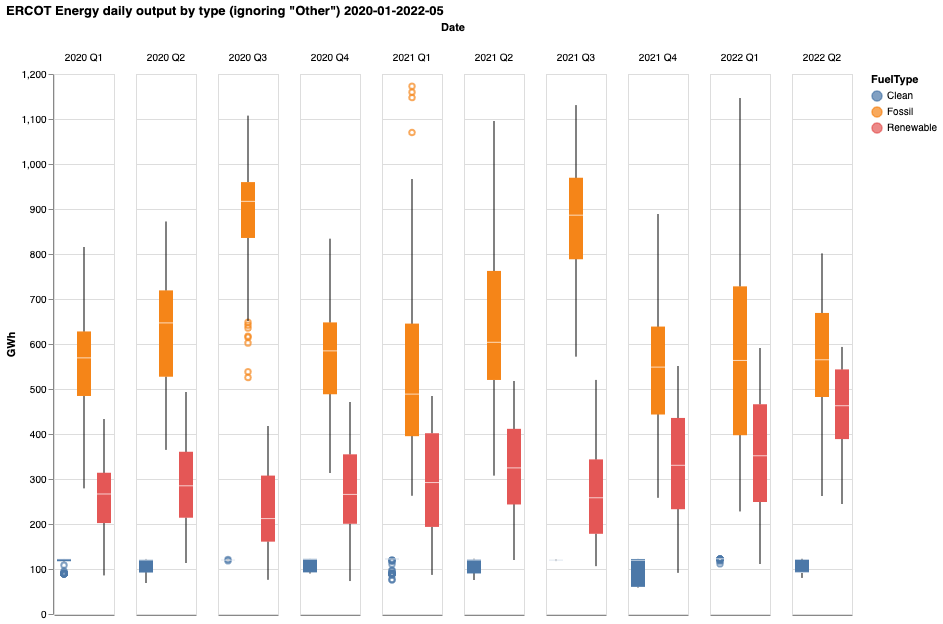

In [11]:
chart = alt.Chart(
    newdf.query('Fuel not in ("ALL SOURCES", "Other")').groupby(['Date', 'FuelType']).sum().reset_index().round(1)
).mark_boxplot(#size=10, extent=0.5
# ).transform_aggregate(
#     # min_pct='min(pct):Q',
#     # max_pct='max(pct):Q',
#     # DailyMax='max(DailyMax):Q',
#     groupby=["Date", 'Fuel']
).encode(
    x=alt.X('FuelType:N', axis=alt.Axis(labels=False, ticks=False), title=None),
    column=alt.Column('yearquarter(Date):T', title="Date"),
    y=alt.Y(
        'Total:Q', title='GWh',
        # 'pct:Q', axis=alt.Axis(format='%'),
        # scale=alt.Scale(domain=[0.0, 1.0]),
        scale=alt.Scale(domainMin=0),

    ),
    color='FuelType:N',
    # tooltip=['yearmonth(Date)','Fuel','DailyMax', 'min(pct):Q', 'max(pct):Q']
).properties(
    title=f'ERCOT Energy daily output by type (ignoring "Other") {date_range}',
    height=height,
)
display(chart)

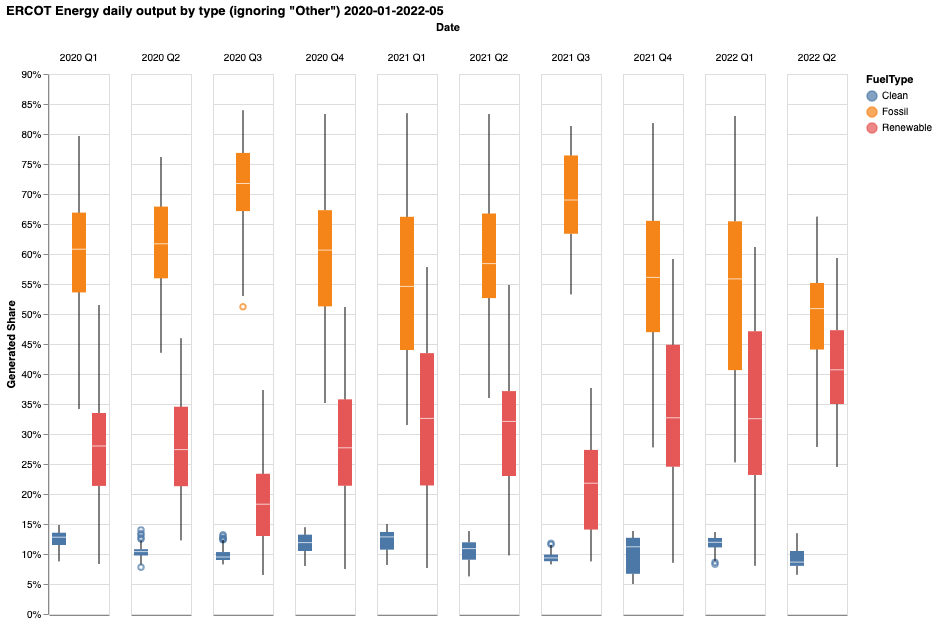

In [12]:
chart = alt.Chart(
    newdf.query('Fuel not in ("ALL SOURCES", "Other")').groupby(['Date', 'FuelType']).sum().reset_index().round(3)
).mark_boxplot(#size=10, extent=0.5
# ).transform_aggregate(
#     # min_pct='min(pct):Q',
#     # max_pct='max(pct):Q',
#     # DailyMax='max(DailyMax):Q',
#     groupby=["Date", 'Fuel']
).encode(
    x=alt.X('FuelType:N', axis=alt.Axis(labels=False, ticks=False), title=None),
    column=alt.Column('yearquarter(Date):T', title="Date"),
    y=alt.Y(
        # 'Total:Q', title='GWh',
        'pct:Q', title='Generated Share', axis=alt.Axis(format='%'),
        # scale=alt.Scale(domain=[0.0, 1.0]),
        # scale=alt.Scale(domainMin=0),

    ),
    color='FuelType:N',
    # tooltip=['yearmonth(Date)','Fuel','DailyMax', 'min(pct):Q', 'max(pct):Q']
).properties(
    title=f'ERCOT Energy daily output by type (ignoring "Other") {date_range}',
    height=height,
)
display(chart)